# Leaky-integrate-and-fire with Bursting

The Leaky Integrate-and-Fire with Burst (LIFB) model extends the basic Leaky Integrate-and-Fire (LIF) model to reproduce burst firing patterns. While a standard LIF with constant input above threshold will fire at a regular, fixed rate, the LIFB can generate clusters of closely-spaced spikes (bursts) followed by periods of quiescence, thanks to the mechanism where one spike temporarily increases excitability. This makes the next spike more likely to occur sooner.

## Key Properties

1. **Burst Firing**: Generates clusters of spikes in rapid succession followed by silent periods
2. **Spike Frequency Adaptation**: Firing rate changes within and between bursts
3. **Dual Timescale Dynamics**: Fast dynamics for within-burst behavior and slow dynamics for burst initiation/termination
4. **Rebound Bursting**: Can generate bursts after inhibitory input

## Mathematical Description

The model is described by three coupled differential equations:

Cm(dV/dt) = -gL(V - EL) - wfast - wslow + Iext

When V ≥ Vth:
  • V is reset to Vreset
  • wfast is incremented: wfast = wfast + bfast
  • wslow is incremented: wslow = wslow + bslow

Fast adaptation dynamics:
tau_fast(dwfast/dt) = afast(V - EL) - wfast

Slow adaptation/bursting dynamics:
tau_slow(dwslow/dt) = aslow(V - EL) - wslow

Parameters:
- V: Membrane potential
- wfast: Fast adaptation variable
- wslow: Slow adaptation/bursting variable
- Cm: Membrane capacitance (typically 1 μF/cm²)
- gL: Leak conductance (typically 0.01-0.03 mS/cm²)
- EL: Leak reversal potential (typically -70 mV)
- Vth: Spike threshold (typically -50 to -55 mV)
- Vreset: Reset potential after spike (typically -65 to -75 mV)
- afast: Fast subthreshold adaptation parameter (typically 5-10 nS)
- bfast: Fast spike-triggered adaptation increment (typically 60-100 pA)
- tau_fast: Time constant of fast adaptation (typically 20-50 ms)
- aslow: Slow subthreshold adaptation parameter (typically 0-2 nS)
- bslow: Slow spike-triggered adaptation increment (typically 20-50 pA)
- tau_slow: Time constant of slow adaptation (typically 200-600 ms)
- wthresh: Threshold for bursting activation (model-specific)
- Iext: External current input

State Variables:
- V: Membrane potential (initialize at EL)
- wfast: Fast adaptation variable (initialize at 0)
- wslow: Slow adaptation variable (initialize at 0)

Time-related variables:
- dt: Time step for numerical integration
- t: Current simulation time
- tmax: Maximum simulation time

## Algorithm

1. Initialize state variables
   - V = EL (resting potential)
   - wfast = 0
   - wslow = 0
   - Create empty list for spike times

2. For each time step from t=0 to t=tmax:
   
   a. Check if spike threshold is reached
      - If V ≥ Vth:
        • Record spike time
        • Reset membrane potential: V = Vreset
        • Increment adaptation variables: 
          wfast = wfast + bfast
          wslow = wslow + bslow
   
   b. Compute derivative terms
      - dV/dt = (-gL(V - EL) - wfast - wslow + Iext) / Cm
      - dwfast/dt = (afast(V - EL) - wfast) / tau_fast
      - dwslow/dt = (aslow(V - EL) - wslow) / tau_slow
   
   c. Update state variables using Euler method
      - V = V + dV/dt * dt
      - wfast = wfast + dwfast/dt * dt
      - wslow = wslow + dwslow/dt * dt
   
   d. Store variables for plotting
      - Record V, wfast, wslow at current time step
   
   e. Increment time: t = t + dt

3. Analyze and visualize results
   - Plot membrane potential (V) vs time
   - Plot adaptation variables (wfast, wslow) vs time
   - Calculate burst statistics (burst duration, interburst interval)
   - Analyze within-burst firing rate vs. between-burst intervals

## Characteristic Behaviors

1. **Burst Initiation**: Bursts typically start with a higher input current or after recovery from adaptation
2. **Within-Burst Adaptation**: Spike frequency within a burst typically decreases due to fast adaptation
3. **Burst Termination**: Accumulation of slow adaptation eventually terminates the burst
4. **Inter-Burst Interval**: Duration between bursts is regulated by the recovery of the slow adaptation variable
5. **Rebound Bursting**: Inhibitory input can trigger a burst upon release due to hyperpolarization-activated mechanisms

## Biological Mechanisms Represented

The dual adaptation variables represent:
- Fast adaptation: Inactivation of Na+ channels and activation of fast K+ currents
- Slow adaptation: Slow Ca2+-dependent K+ currents and Ca2+ accumulation
- Burst facilitation: Ca2+-dependent depolarizing currents and hyperpolarization-activated channels
- Rebound mechanisms: Deinactivation of T-type Ca2+ channels during hyperpolarization

## Applications

The LIFB model is particularly useful for modeling:
- Chattering neurons in cortex
- Burst-firing neurons in thalamus and hippocampus
- Central pattern generators that produce rhythmic output
- Sensory neurons that encode stimulus intensity through burst patterns
- Neurological conditions characterized by abnormal bursting activity


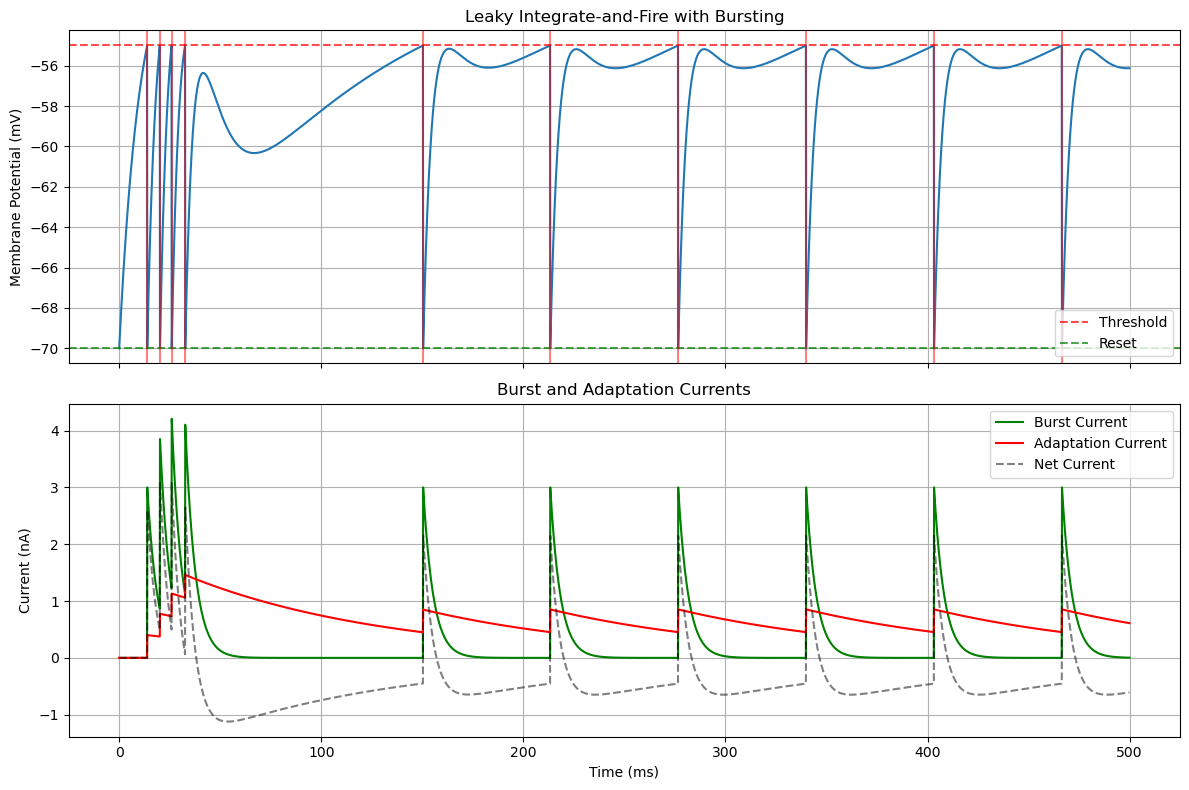

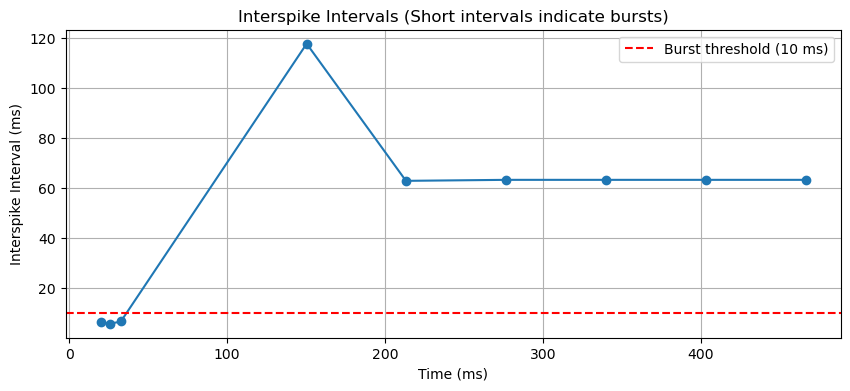

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class LIFB():
    def __init__(self, Cm, R, V_th, V_reset, V_rest, I, time_steps, 
                 burst_amplitude=3.0, tau_burst=5.0, 
                 adapt_amplitude=1.0, tau_adapt=100.0):
        self.Cm = Cm            # Membrane capacitance
        self.R = R              # Membrane resistance
        self.V_th = V_th        # Threshold voltage
        self.V_reset = V_reset  # Reset voltage
        self.V_rest = V_rest    # Resting voltage
        self.I = I              # Input current
        self.tau = R * Cm       # Membrane time constant
        
        # Bursting parameters
        self.burst_amplitude = burst_amplitude  # Strength of burst current (nA)
        self.tau_burst = tau_burst              # Burst current decay time constant (ms)
        
        # Adaptation parameters (post-burst hyperpolarization)
        self.adapt_amplitude = adapt_amplitude  # Strength of adaptation current (nA)
        self.tau_adapt = tau_adapt              # Adaptation current decay time constant (ms)
        
        self.time_steps = time_steps

    def simulate(self):
        # Initialize arrays for storing voltage, currents, and spike times
        voltage = [self.V_reset]    # Start at reset voltage
        burst_current = [0]         # Excitatory burst current
        adapt_current = [0]         # Inhibitory adaptation current
        spikes = []
        
        dt = self.time_steps[1] - self.time_steps[0]  # Time step size
        
        # Simulate for each time step
        for t_idx, t in enumerate(self.time_steps[:-1]):
            # Current voltage and currents
            V_current = voltage[-1]
            burst_I = burst_current[-1]
            adapt_I = adapt_current[-1]
            
            # Decay burst and adaptation currents
            burst_I_next = burst_I * np.exp(-dt / self.tau_burst)
            adapt_I_next = adapt_I * np.exp(-dt / self.tau_adapt)
            
            # Calculate net current (input + burst - adaptation)
            I_net = self.I + burst_I - adapt_I
            
            # Using the exact solution for the voltage differential equation
            V_inf = I_net * self.R + self.V_rest  # asymptotic voltage
            V_next = V_inf + (V_current - V_inf) * np.exp(-dt / self.tau)
            
            # Check for spike
            if V_next >= self.V_th:
                spikes.append(t + dt)
                V_next = self.V_reset
                
                # After spike: increase burst current (promotes bursting)
                burst_I_next += self.burst_amplitude
                
                # After spike: increase adaptation current (eventually stops the burst)
                adapt_I_next += self.adapt_amplitude
            
            voltage.append(V_next)
            burst_current.append(burst_I_next)
            adapt_current.append(adapt_I_next)
        
        return voltage, burst_current, adapt_current, spikes
    
    def plot_results(self, voltage, burst_current, adapt_current, spikes):
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot membrane potential
        ax1.plot(self.time_steps, voltage)
        ax1.axhline(y=self.V_th, color='r', linestyle='--', alpha=0.7, label='Threshold')
        ax1.axhline(y=self.V_reset, color='g', linestyle='--', alpha=0.7, label='Reset')
        
        # Plot spikes as vertical lines
        for spike in spikes:
            ax1.axvline(x=spike, color='r', linestyle='-', alpha=0.5)
        
        ax1.set_ylabel('Membrane Potential (mV)')
        ax1.set_title('Leaky Integrate-and-Fire with Bursting')
        ax1.legend()
        ax1.grid(True)
        
        # Plot currents
        ax2.plot(self.time_steps, burst_current, 'g-', label='Burst Current')
        ax2.plot(self.time_steps, adapt_current, 'r-', label='Adaptation Current')
        ax2.plot(self.time_steps, np.array(burst_current) - np.array(adapt_current), 'k--', 
                 label='Net Current', alpha=0.5)
        
        ax2.set_xlabel('Time (ms)')
        ax2.set_ylabel('Current (nA)')
        ax2.set_title('Burst and Adaptation Currents')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Also plot the interspike intervals to show bursting effect
        if len(spikes) > 1:
            intervals = np.diff(spikes)
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(spikes[1:], intervals, 'o-')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Interspike Interval (ms)')
            ax.set_title('Interspike Intervals (Short intervals indicate bursts)')
            
            # Add a horizontal line to help visualize burst threshold
            burst_threshold = 10  # ms (customize based on your parameters)
            ax.axhline(y=burst_threshold, color='r', linestyle='--', 
                      label=f'Burst threshold ({burst_threshold} ms)')
            ax.legend()
            ax.grid(True)
            plt.show()

    # LIF with Bursting simulation
t_max = 500  # ms
dt = 0.1     # ms
time_steps = np.arange(0, t_max, dt)

# Create bursting neuron
lifb_neuron = LIFB(
    Cm=1,                # nF
    R=10,                # MΩ
    V_th=-55,            # mV
    V_reset=-70,         # mV
    V_rest=-70,          # mV
    I=2.0,               # nA (baseline current)
    time_steps=time_steps,
    burst_amplitude=3.0, # nA (promotes bursting)
    tau_burst=5.0,       # ms (fast decay of burst current)
    adapt_amplitude=0.4, # nA (gradually stops bursting)
    tau_adapt=100.0      # ms (slow decay of adaptation)
)

# Run simulation
voltage, burst_current, adapt_current, spikes = lifb_neuron.simulate()

# Plot results
lifb_neuron.plot_results(voltage, burst_current, adapt_current, spikes)